# Algorithm Performance Assessment

We compare the outcome of the prototype Level-2 SIC algorithm against ground-truth from the the Test Cards. The main comparison is against the so-called "Polar Scene 1" prepared by the ESA CIMR SCEPS study. We use the v2.1 simulated L1B file (January 2024).

## L1 E2ES Demonstration Reference Scenario (Picasso) scene definition

At this stage, we base our performance assessment on the more realistic "Polar Scene 1" prepared by the ESA CIMR SCEPS study. The scene represents a typical winter polar case in the area around Svalbard and the Barents Sea. For the v2.1 simulation, the SIC field used by SCEPS in their simulation is from a model run (NEMO/CICE system).  

The geophysical parameters are first processed through the SCEPS forward simulator to generate Top-of-Atmosphere (TOA) brightness temperatures at all microwave channels, and second through the SCEPS instrument simulator to prepare a simulated L1B file. The input data and various parts of the simulator are documented in SCEPS reports.

## Algorithm Performance Metrics (MPEF)

For SIC, the two main metrics are:
* the **bias** (arithmetic average of the errors)
* the **RMSE** (standard deviation of the errors)

For SIED, the selected metric is the Integrated Ice Edge Error (**IIEE**) of Goeesling et al. (2016).

*Goessling, H. F., S. Tietsche, J. J. Day, E. Hawkins, and T. Jung (2016), Predictability of the Arctic sea ice edge, Geophys. Res. Lett., 43, 1642–1650, doi:10.1002/2015GL067232.*

## Algorithm Calibration Data Set (ACDAT)

The L2 SIC algorithm is tuned in the Offline Preparation notebook. We have several types of tuning, and this chapter compares the results from these different tunings:
* Static tuning against ESA CCI RRDP SIC0 and SIC1 data;
* Dynamic tuning against the simulated CIMR L1B TBs;

## Algorithm Validation Data Set (AVDAT)

The L2 SIC is compared against the SIC (variable `sea_ice_concentration`) from the GEO files in the SCEPS simulations.


## Test Results using Demonstration Reference Scenario

In the following, we compare the result of the prototype L2 SIC algorithm (as stored in a L2 netCDF product file produced in the previous sections of this ATBD) against the ground truth from the SCEPS Polar Scene 1. The comparison is made in various ways to better understand the observed differences.

In [1]:
import xarray as xr
import numpy as np
from copy import copy

import pyresample as pr

from matplotlib import pylab as plt
import cmocean
import matplotlib

from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp

input_test_card = 'sceps_polar_1'

In [52]:
# read the SIC from the L2 netCDF file:
l2_n = '../data/output/cimr_devalgo_l2_sic_ease2-1.0km-testcard_sceps-polar1.nc'
ds = xr.open_dataset(l2_n)
l2_sic = ds['ice_conc'][0,:].data
l2_rsic = ds['raw_ice_conc_values'][0,:].data
l2_sied = ds['ice_edge'][0,:].data.astype('int16')

adef,_ = pr.utils.load_cf_area(l2_n, )
cart_crs = adef.to_cartopy_crs()

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [53]:
main_algo = ds.attrs['algorithm_name']
print(" +++ CHARACTERISTICS +++ ")
print(ds.attrs['algorithm_name'])
print(ds.attrs['use_oza_adjusted_tbs'])
print(ds.attrs['algorithm_tuning'])

 +++ CHARACTERISTICS +++ 
CKA@KA
Yes
CIMRL1B-ALLFEEDS


### Compare L2 SIC (CKA@KA) against the reference SIC

Access the reference SIC from the Test Card and compare to the SIC retrieved by the algorithm.

This requires access to the SCEPS files.

In [54]:
owci_flg_cice = 2
owci_flg_ow   = 1
owci_flg_miz  = 3

tc_tbs = dict()
if input_test_card == 'sceps_polar_1':
    # load SIC truth from the GEO file
    geo_file = '/home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_GEO_TDS/SCEPS/Cards/SCEPS_Geo_Polar_Scene_1/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc'
    tc_ds = xr.open_dataset(geo_file)
    print("GEO file: ", geo_file)
    tc_sic = tc_ds['sea_ice_concentration'][0,:,:].to_masked_array().transpose()
    
    # load TOA Tbs from the TOA file
    toa_file = '/home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_TOA_TDS/SCEPS/SCEPS_TOA_Geo_Polar_Scene_1/cimr_sceps_toa_card_devalgo_polarscene_1_20161217_v2p0_aa_000.nc'
    tc_l1b = xr.open_dataset(toa_file)
    print("TOA file: ", toa_file)
    toa_band_name = 'toa_tbs_{b:}_{p:}po'
    
    tc_tbs['tb06v'] = tc_l1b[toa_band_name.format(b='C', p='V')].isel(time=0).sel(incidence_angle=55).data.transpose()
    tc_tbs['tb19v'] = tc_l1b[toa_band_name.format(b='Ku', p='V')].isel(time=0).sel(incidence_angle=55).data.transpose()
    tc_tbs['tb37v'] = tc_l1b[toa_band_name.format(b='Ka', p='V')].isel(time=0).sel(incidence_angle=55).data.transpose()
    tc_tbs['tb37h'] = tc_l1b[toa_band_name.format(b='Ka', p='H')].isel(time=0).sel(incidence_angle=55).data.transpose()
    
    tc_owci = np.zeros_like(tc_tbs['tb06v']).astype('int')
    tc_owci[-500:-20,20:500] = owci_flg_cice
    tc_owci[20:500,-500:-20] = owci_flg_ow
    
    # how many pixels to mask around the test card
    margin = 3
    
else:
    tc_fn = os.path.join(tc_path, tc_fn)
    tc_l1b = xr.open_dataset(tc_fn,)
    tc_surf = tc_l1b['surfaces'].data
    
    # how many pixels to mask around the test card
    margin = 15
    
    # use the surfaces variable to find where is ice and water
    tc_ice_mask = (tc_surf == 1)+(tc_surf == 2)
    tc_ocean_mask = (tc_surf == 5)+(tc_surf == 6)+(tc_surf == 7)+(tc_surf == 8)
    tc_oceanice_mask = tc_ice_mask + tc_ocean_mask
        
    tc_sic = np.ma.array(np.zeros_like(tc_surf))
    tc_sic[tc_ice_mask] = 100.
    tc_sic[~tc_oceanice_mask] = np.ma.masked
    
    # load TOA Tbs
    toa_band_name = '{b:}_band_{p:}'
    
    tc_tbs['tb06v'] = tc_l1b[toa_band_name.format(b='C', p='V')].to_masked_array()
    tc_tbs['tb19v'] = tc_l1b[toa_band_name.format(b='Ku', p='V')].to_masked_array()
    tc_tbs['tb37v'] = tc_l1b[toa_band_name.format(b='Ka', p='V')].to_masked_array()
    tc_tbs['tb37h'] = tc_l1b[toa_band_name.format(b='Ka', p='H')].to_masked_array()
    print(tc_tbs['tb06v'].shape, tc_tbs['tb06v'].min(), tc_tbs['tb06v'].max())
    
    tc_owci = np.zeros_like(tc_tbs['tb06v']).astype('int')
    tc_owci[tc_sic==1] = owci_flg_cice
    tc_owci[tc_sic==0] = owci_flg_ow
    
    if input_test_card == 'radiometric':    
        # Remove the top-most and right-most areas of the Radiometric TestCard
        #   Because we focus on the cells for the time being.
        _margin = 200
        tc_geom = np.ones_like(tc_surf).astype('bool')
        tc_geom[:,:_margin] = False
        tc_geom[-_margin:,:] = False
        tc_sic[~tc_geom] = np.ma.masked
        for ch in tc_tbs.keys():
            tc_tbs[ch][~tc_geom] = np.ma.masked
    

# Remove the border of the TestCard (because of the spill-over from the 0K from outside the scene):
tc_border = np.ones_like(tc_sic).astype('bool')
tc_border[-margin:,:] = False
tc_border[:margin,:] = False
tc_border[:,-margin:] = False
tc_border[:,:margin] = False
tc_sic[~tc_border] = np.ma.masked
for ch in tc_tbs.keys():
    tc_tbs[ch] = np.ma.asarray(tc_tbs[ch])
    tc_tbs[ch][~tc_border] = np.ma.masked

# evaluate Reference SIED:
tc_sied = np.ma.where(tc_sic >= 15, 1, 0).astype('int16')

GEO file:  /home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_GEO_TDS/SCEPS/Cards/SCEPS_Geo_Polar_Scene_1/cimr_sceps_geo_card_devalgo_polarscene_1_20161217_harmonised_v2p0_surface.nc
TOA file:  /home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/Ref_scen_TOA_TDS/SCEPS/SCEPS_TOA_Geo_Polar_Scene_1/cimr_sceps_toa_card_devalgo_polarscene_1_20161217_v2p0_aa_000.nc


#### Coarsen the 1km SIC results to the expected spatial resolution of the L2 SIC product

Both the Test Card and the L2 SIC product are prepared on an EASE2 polar grid with **1 km spacing**. However the planned resolution for the L2 SIC is coarser, possibly closer to **4 km**. Here we first coarsen both 2D fields before computing the metrics, to reduce unwanted (potential) gridding / remapping artefacts.

In [55]:
def blockshaped(arr, nrows, ncols):
    """ 
    from: http://stackoverflow.com/questions/16873441/form-a-big-2d-array-from-multiple-smaller-2d-arrays/16873755#16873755
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

coarsening_factor = 4
coarsened_shape = tuple((np.array(l2_sic.shape)//coarsening_factor).astype('int'))
area_km2 = (1 * coarsening_factor)**2

l2_sic = blockshaped(l2_sic, coarsening_factor, coarsening_factor).mean(axis=1).mean(axis=1).reshape(coarsened_shape)
l2_rsic = blockshaped(l2_rsic, coarsening_factor, coarsening_factor).mean(axis=1).mean(axis=1).reshape(coarsened_shape)
tc_sic = blockshaped(tc_sic, coarsening_factor, coarsening_factor).mean(axis=1).mean(axis=1).reshape(coarsened_shape)

tc_sied = blockshaped(tc_sied, coarsening_factor, coarsening_factor).min(axis=1).min(axis=1).reshape(coarsened_shape)
l2_sied = blockshaped(l2_sied, coarsening_factor, coarsening_factor).min(axis=1).min(axis=1).reshape(coarsened_shape)

tc_owci = blockshaped(tc_owci, coarsening_factor, coarsening_factor).max(axis=1).max(axis=1).reshape(coarsened_shape)


#### Compare maps of SIC and maps of SIC differences

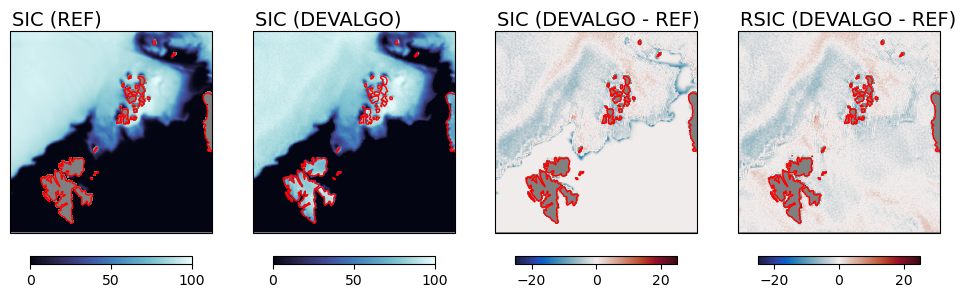

In [41]:
cmap_sic = copy(cmocean.cm.ice)
cmap_sic.set_bad('grey')
vmin = 0
vmax = 100

cmap_dif = copy(cmocean.cm.balance)
cmap_dif.set_bad('grey')
dmin = -25
dmax = -dmin

sic_diff = l2_sic - tc_sic
rsic_diff = l2_rsic - tc_sic

# visualize / plot
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(12,6), subplot_kw=dict(projection=cart_crs))
# first col : SIC truth
c = ax[0].imshow(tc_sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax[0].coastlines(color='red')
ax[0].text(0.01,1.01,'SIC (REF)',va='bottom',fontsize=14,transform=ax[0].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
# second col : SIC algorithm
c = ax[1].imshow(l2_sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax[1].coastlines(color='red')
ax[1].text(0.01,1.01,'SIC (DEVALGO)',va='bottom',fontsize=14,transform=ax[1].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
# third col : SIC diff
c = ax[2].imshow(sic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax)
ax[2].coastlines(color='red')
ax[2].text(0.01,1.01,'SIC (DEVALGO - REF)',va='bottom',fontsize=14,transform=ax[2].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
# fourth col : rSIC diff
c = ax[3].imshow(rsic_diff, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_dif,vmin=dmin,vmax=dmax)
ax[3].coastlines(color='red')
ax[3].text(0.01,1.01,'RSIC (DEVALGO - REF)',va='bottom',fontsize=14,transform=ax[3].transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()


The maps above show the Reference SIC (Far left), the L2 SIC (field *ice_conc*) from `CKA@KA` (Left), the difference of the two (Right), and the difference between field *raw_ice_conc_values* (still from `CKA@KA` results) and the Reference SIC.

Looking at the two first map, it is apparent that the L2 algorithm captures the main features of the Reference SIC field, including in the partial concentration areas north East for Franz Joseph Land (top-right corner of the maps). Details of the sea-ice edge regions seem to be well capture, including in the Barents Sea. The coastal polynyas north for Franz Joseph Land, that are often observed in case of nortwardly winds.

Looking at the 3rd map *(DEVALGO - REF)* we see that differences are both positive and negatives, mostly in the range [-5 ; +5]. The difference is exactly 0% over the ocean, illustrating how the Open Water Filter (OWF) implemented in the L2 SIC algorithm successfully sets SIC to 0% where it detects open water. The most pronounced blue shades (L2 SIC < REF SIC) are seen along the ice edge, which can indicate that the OWF cut away actual low-concentration sea ice. This is indeed a known caveat of weather filters that they can be too greedy and remove true low-concentration (and/or thin) sea ice (see the description in the ATBD).

The 4th map *(DEVALGO RAW - REF)* confirms that the Open Water Filter is the cause of the underestimation seen in the sea-ice edge region in the 3rd map: the *raw_ice_conc_values* variable indeed holds the SIC values *before* applying the OWF and the thresholding to the [0 ; 100] range. When OWF is not applied, there is no specific underestimation by the L2 SIC in the marginal ice zone. In this 4th map, the difference is no more exactly 0% over the ocean (since the OWF was not applied to set SICs to 0% there). The differences over the ocean show the actual uncertainty of SIC before the OWF is applied, and is a good indicator of the uncertainty of SIC in the low concentration range.

Next, we will look at histograms and metrics of the differences.

#### Compare as histogram of differences, with BIAS and RMSE (full range of SIC)

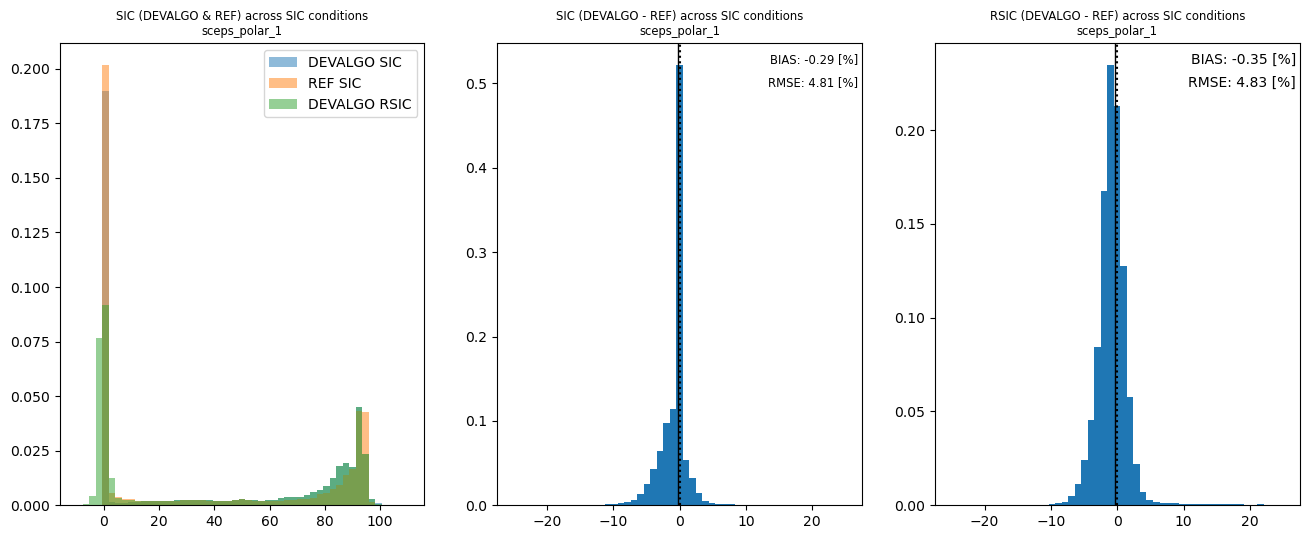

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6),)

nbins=51

ax[0].hist(l2_sic.flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='DEVALGO SIC')
ax[0].hist(tc_sic.flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='REF SIC')
ax[0].hist(l2_rsic.flatten(), bins=nbins, range=[-10,110], density=True, alpha=0.5, label='DEVALGO RSIC')
ax[0].legend()
ax[0].set_title("SIC (DEVALGO & REF) across SIC conditions\n{}".format(input_test_card), fontsize='small')

sic_diff_1d = sic_diff.compressed()
hist_range = (dmin, dmax)
ax[1].axvline(x=0, color='k', linestyle=':')
ax[1].hist(sic_diff_1d, bins=nbins, range=hist_range, density=True)
ax[1].axvline(x=sic_diff_1d.mean(), color='k', linestyle='-', lw=1)
ax[1].set_title("SIC (DEVALGO - REF) across SIC conditions\n{}".format(input_test_card), fontsize='small')
ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_1d.mean()),
        transform=ax[1].transAxes, ha='right', va='top', fontsize='small')
ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_1d.std()),
        transform=ax[1].transAxes, ha='right', va='top', fontsize='small')


rsic_diff_1d = rsic_diff.compressed()
hist_range = (dmin, dmax)
ax[2].axvline(x=0, color='k', linestyle=':')
ax[2].hist(rsic_diff_1d, bins=nbins, range=hist_range, density=True)
ax[2].axvline(x=rsic_diff_1d.mean(), color='k', linestyle='-', lw=1)
ax[2].set_title("RSIC (DEVALGO - REF) across SIC conditions\n{}".format(input_test_card), fontsize='small')
ax[2].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(rsic_diff_1d.mean()),
        transform=ax[2].transAxes, ha='right', va='top', )
ax[2].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(rsic_diff_1d.std()),
        transform=ax[2].transAxes, ha='right', va='top', )

plt.show()

Three histograms are shown above. On the left a comparison of three histograms over the full range of SIC, at the center an histogram of the difference between L2 SIC (`CKA@KA` *ice_conc*) and the Reference SIC, to the right an histogram of the difference betwen L2 SIC (`CKA@KA` *raw_ice_conc_values*) and the Reference SIC.

The orange bars (left-most panel) are for the reference SIC as read from the SCEPS GEO files. It shows that the most common value is 0%SIC (over the open ocean). Over consolidated / pack ice, the Reference SIC does not fully reach 100% (which we would have expected for a mid-December conditions in the Arctic). The blue bars (left-most panel) are for the *filtered* L2 SIC, after applying the OWF. We observe a good match at 0% SIC, while the SIC over consolidated / pack ice is slightly lower than the Reference SIC. The green bars (lef-most panel) are for the *non-filtered* SICs and show more spread around 0% SIC, including negative SIC values. These are the values that are set to 0% by the OWF in the *filtered* SIC (blue bars). At consolidate / pack ice conditions, the green bars exactly overlap the blue bars since the OWF does not modify SICs at high concentrations, and because the Reference SIC does not reach to 100%. In actual retrieval conditions, the blue bars would show more values at 100% SIC, and the green bars would show SICs higher than 100%.

The histogram plot in the center panel reveals that SIC differences are almost entirely contained in the [-10 ; +10] range. The computed RMSE is 4.8%. This histogram has a high peak at 0% (difference) which mostly corresponds to the action of the OWF over the ocean.

The histogram plot in the right panel is for the difference betwen L2 SIC (`CKA@KA` *raw_ice_conc_values*) and the Reference SIC reveals that SIC differences are almost entirely contained in the [-10 ; +10] range. The computed RMSE is 4.8%.

#### Compare as histogram of differences, with BIAS and RMSE (Open Water and Closed Ice)

Next we look at histograms and validation metrics for the two ends of the SIC range: Open Water and Consolidated Ice. We first show a map of the regions where the Open Water and Closed Ice conditions are extracted from:

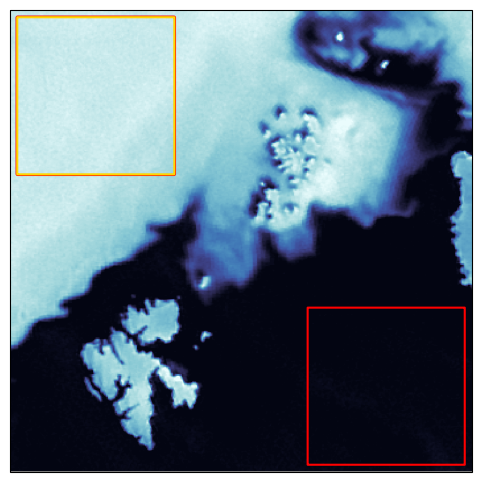

In [8]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=cart_crs))

ax.imshow(l2_rsic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=vmin,vmax=vmax)
ax.contour(tc_owci, levels=(0.99, 1.99), colors=('red','gold'), transform=cart_crs, extent=cart_crs.bounds, origin='upper')
plt.show()

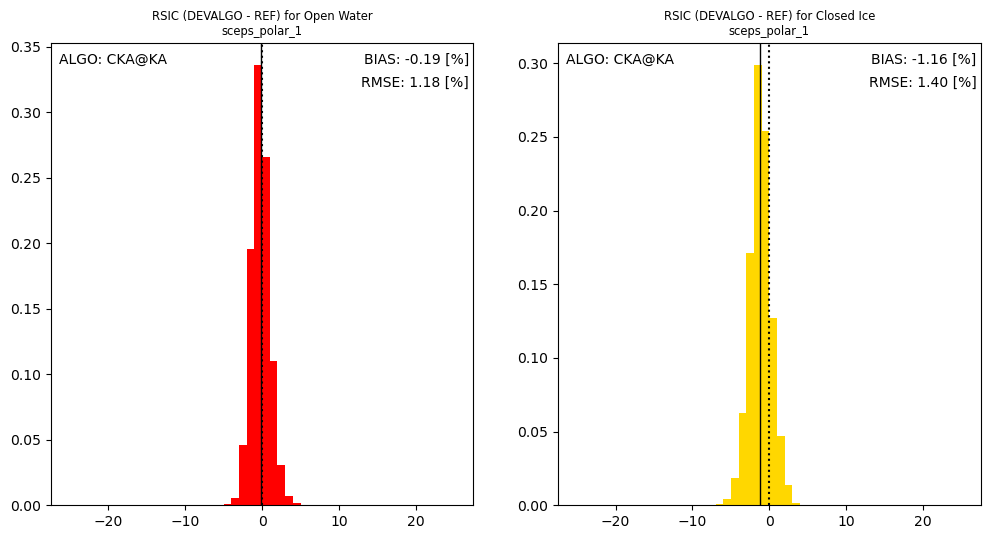

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,6),)

sic_diff_ow_1d = rsic_diff[tc_owci==1].compressed()
hist_range = (dmin, dmax)
ax[0].axvline(x=0, color='k', linestyle=':')
ax[0].hist(sic_diff_ow_1d, bins=50, range=hist_range, density=True, color='red')
ax[0].axvline(x=sic_diff_ow_1d.mean(), color='k', linestyle='-', lw=1)
ax[0].set_title("RSIC (DEVALGO - REF) for Open Water\n{}".format(input_test_card), fontsize='small')
ax[0].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ow_1d.mean()),
        transform=ax[0].transAxes, ha='right', va='top')
ax[0].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ow_1d.std()),
        transform=ax[0].transAxes, ha='right', va='top')
ax[0].text(0.02,0.98, 'ALGO: {}'.format(main_algo.upper()),
            transform=ax[0].transAxes, ha='left', va='top')

sic_diff_ci_1d = rsic_diff[tc_owci==2].compressed()
hist_range = (dmin, dmax)
ax[1].axvline(x=0, color='k', linestyle=':')
ax[1].hist(sic_diff_ci_1d, bins=50, range=hist_range, density=True, color='gold')
ax[1].axvline(x=sic_diff_ci_1d.mean(), color='k', linestyle='-', lw=1)
ax[1].set_title("RSIC (DEVALGO - REF) for Closed Ice\n{}".format(input_test_card), fontsize='small')
ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ci_1d.mean()),
        transform=ax[1].transAxes, ha='right', va='top')
ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ci_1d.std()),
        transform=ax[1].transAxes, ha='right', va='top')
ax[1].text(0.02,0.98, 'ALGO: {}'.format(main_algo.upper()),
            transform=ax[1].transAxes, ha='left', va='top')
plt.show()

The two histograms above show the difference between the *unfiltered* SICs (field `raw_ice_conc_values`) from the L2 SIC to the Reference SIC over Open Water conditions (left panel, red) and Closed Ice (right panel, yellow). We remind that the SIC over Closed Ice conditions is not 100% but rather in the 85 - 95% range.

The two histograms report the retrieval accuracy away from the marginal ice zone, which is usually how SIC retrieval algorithms are typically evaluated because it is difficult to obtain realistic reference measurements of intermediate SIC conditions that are perfectly collocated in time with satellite acquisition.

The bias reported for Open Water conditions (left panel) is very small (-0.2 % SIC). This is expected since the SIC algorithm was partly tuned on the simulated CIMR L1B brightness temperatures duringt the Offline Preparation step. Because we only had a single simulated L1B swath available, we had to train the SIC algorithm on the same swath that we applied it to. As mentionned above, the operational setup would be different since the algorithm would be tuned regularly (e.g. daily) against a rolling archive of CIMR swaths (typically 5-7 past days) and not directly on the swath bring processed. Nonetheless, experience of such dynamic tuning in the context of the ESA CCI or OSI SAF products show that low bias (< 0.5%) can be achieved with the dynamic tuning over open water conditions.

The bias reported for Closed Ice conditions (right panel) is slithly larger (-1.2 % SIC). Here we remind that the high-concentration range of the SIC algorithm was not trained dynamically against the simulated L1B TBs, but rather directly against the CCI Sea Ice Round-Robin Data Package (RRDP) SIC1 conditions, that collects both AMSR-E and AMSR2 TBs. The tuning is indirect since, to the best of our knowledge, the parametric sea-ice emissivity model used in the SCEPS simulator is also tuned against the same CCI RRDP SIC1 conditions. We could not tune against the simulated TBs because this would have required a significant number of samples over near 100% SIC conditions, while the Reference SIC is in the 85 - 95% range. Experience from the ESA CCI or OSI SAF products show that small (negative) biases can be achieved for high SIC range using dynamic tuning, but that regional biases can remain with different sea-ice types (typically negative bias for multiyear-ice conditions and positive biases for first-year ice conditions). The impact of sea-ice type on the performance of the selected L2 SIC algorithm could not be investigated here because the sea-ice emissivity model used to generate the SCEPS Polar Scene 1 (v2.1) does not include a dependency on sea-ice type (and because this region would mostly have first-year ice cover in reality).

The RMSEs over Open Water and Closed Ice conditions are very similar and are less than 1.5%. This is smaller than the RMSEs reported in previous sections (that were for the whole SIC range at once) and smaller than the target requirement from the CIMR MRD for the L2 SIC product (5%). Such excellent performance are probably because:
1. the OW (red) and CI (yellow) evaluation regions avoid the Marginal Ice Zone and intermediate ice concentration regions, which is where footprint-mismatch and resampling errors have most impact;
2. the simulated TBs do not necessarily cover the typical range of geophysical variability (e.g. wind speeds over the ocean, sea-ice type dependency, etc...).

While staying careful in extrapolating the results above to potential in-flight performances, we note that previous studies, e.g. in OSI SAF and ESA CCI have shown that RMSE < 5% could be achieved (in winter freezing conditions). The `CKA@KA` algorithm applied to CIMR L1B data has a strong potential to achieve the MRD requirements and beyond.

#### Compare SIED with Integrated Ice Edge Error and related metrics

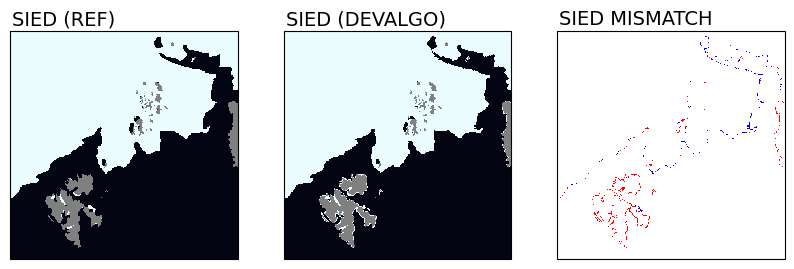

In [59]:
def prepare_IIEE_mask(l2_sied, tc_sied):
        
    Flag_SIE = np.full(np.shape(l2_sied), np.nan)
    Flag_SIE[tc_sied == l2_sied] = 0
    Flag_SIE[tc_sied < l2_sied] = 1
    Flag_SIE[tc_sied > l2_sied] = -1
    Flag_SIE[(tc_sied==np.ma.masked)+(l2_sied==np.ma.masked)] = 0
    
    return Flag_SIE

l2_sied = np.ma.array(l2_sied, mask=tc_sied.mask)
iiee_field = prepare_IIEE_mask(l2_sied, tc_sied)

fig, ax = plt.subplots(figsize=(10,8), ncols=3, sharex=True, sharey=True, subplot_kw=dict(projection=cart_crs))

ax[0].imshow(tc_sied, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=0,vmax=1, interpolation='none')
ax[0].text(0.01,1.01,'SIED (REF)',va='bottom',fontsize=14,transform=ax[0].transAxes)

ax[1].imshow(l2_sied, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap_sic,vmin=0,vmax=1, interpolation='none')
ax[1].text(0.01,1.01,'SIED (DEVALGO)',va='bottom',fontsize=14,transform=ax[1].transAxes)

ax[2].imshow(iiee_field, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=matplotlib.cm.bwr,vmin=-1,vmax=1, interpolation='none')

ax[2].text(0.01,1.01,'SIED MISMATCH',va='bottom',fontsize=14,transform=ax[2].transAxes)
#ax[0].set_xlim(1000000,None)
#ax[0].set_ylim(-1000000,None)

plt.show()

The maps above show a zoom of the Reference Sea Ice Edge (SIC > 15%), the L2 SIED (computed by the L2 algorithm based on the `CKA@KA` SIC), and a visualization of the agreement and mismatch between the two. White color is used where both SIED products agree. Blue where the L2 SIED misses sea-ice (underestimation), and red where the L2 SIED overestimates the sea-ice cover.

From this example, it is apparent that the L2 SIED understimates the sea-ice cover in the marginal ice zone, especially in presence of thin sea ice (eastern part of the domain). Conversely, it detects more sea ice than there is along the coasts (land is grey in the left-most panel).

The underestimation is not a surprise and might be a consequence of:
1. the SIED product being computed from the *filtered* SIC field (after OWF);
2. the SIC being currently slightly low-biased because of its non-optimal tuning (see the results on SIC above).

The overstimation along the coastline was also expected and can be improved in the future CIMR L2 processing by:
1. detecting and masking land-dominated FoVs ahead of the SIC processing (currently all FoVs are processed and gridded into the final product);
2. implementing a land/water spill-over correction of the TBs as a pre-processing to the L2 algorithms (including SIC);

In [60]:
def compute_siedge_metrics(l2_sied, tc_sied, area_km2):
    
    Flag_SIE = prepare_IIEE_mask(l2_sied, tc_sied)
    
    Underestimation = np.sum(Flag_SIE == -1) * area_km2
    Overestimation = np.sum(Flag_SIE == 1) * area_km2
    
    IIEE_metric = Underestimation + Overestimation
    return(IIEE_metric, Underestimation, Overestimation)

IIEE, UE, OE = compute_siedge_metrics(l2_sied, tc_sied, area_km2)
print("Integrated Ice Edge Error: ", IIEE)
print("UnderEstimation: ", UE)
print("OverEstimation: ", OE)

Integrated Ice Edge Error:  20624
UnderEstimation:  7376
OverEstimation:  13248


#### Performance evaluation of the intermediate SIC results from `CKA`, `KKA` and `KA`

For illustration purposes, show the validation statistics obtained from the *intermediate* SIC algorithms.


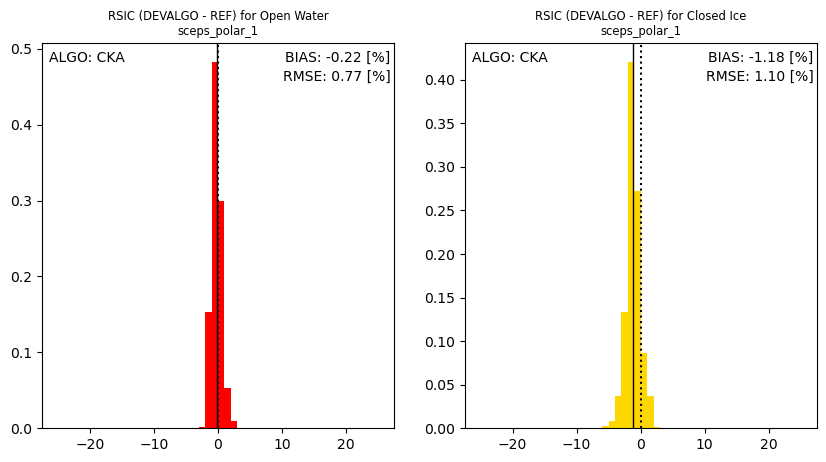

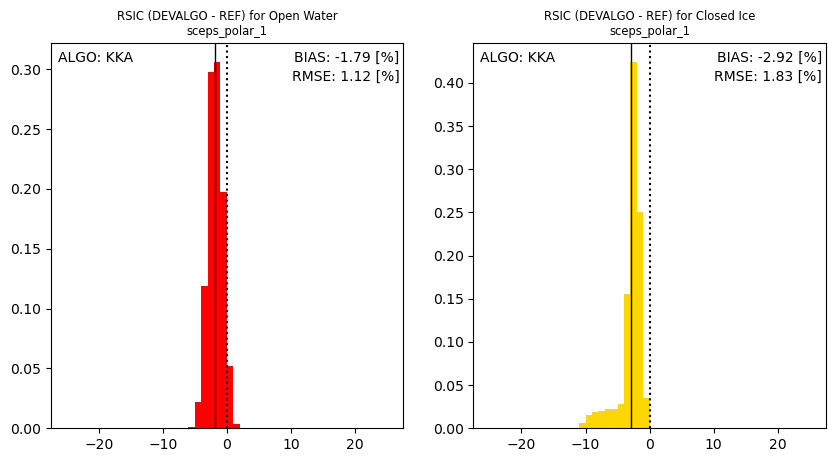

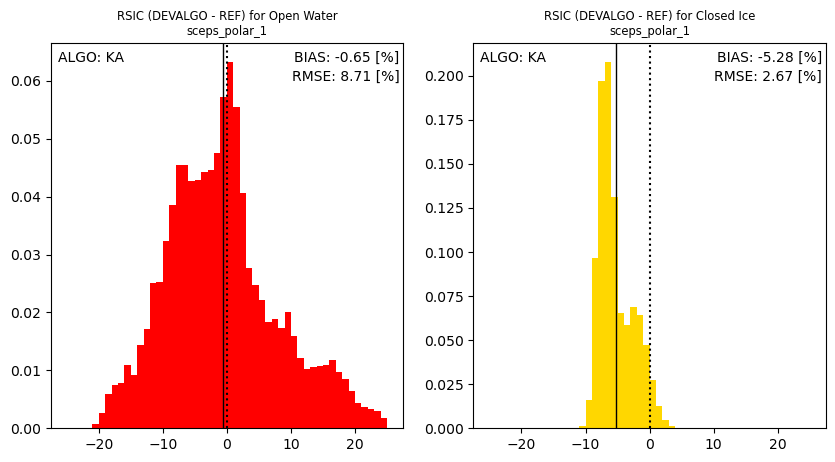

In [25]:
for alg in ('CKA', 'KKA', 'KA'):
    # read the SIC from the L2 netCDF file:
    l2_n = '../data/output/cimr_devalgo_l2_sic-{}_ease2-1.0km-testcard_sceps-polar1.nc'.format(alg)
    ds = xr.open_dataset(l2_n)
    _l2_sic = ds['ice_conc'][0,:].data
    _l2_rsic = ds['raw_ice_conc_values'][0,:].data

    _l2_sic = blockshaped(_l2_sic, coarsening_factor, coarsening_factor).mean(axis=1).mean(axis=1).reshape(coarsened_shape)
    _l2_rsic = blockshaped(_l2_rsic, coarsening_factor, coarsening_factor).mean(axis=1).mean(axis=1).reshape(coarsened_shape)

    _sic_diff = _l2_sic - tc_sic
    _rsic_diff = _l2_rsic - tc_sic

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,5),)

    sic_diff_ow_1d = _rsic_diff[tc_owci==1].compressed()
    hist_range = (dmin, dmax)
    ax[0].axvline(x=0, color='k', linestyle=':')
    ax[0].hist(sic_diff_ow_1d, bins=50, range=hist_range, density=True, color='red')
    ax[0].axvline(x=sic_diff_ow_1d.mean(), color='k', linestyle='-', lw=1)
    ax[0].set_title("RSIC (DEVALGO - REF) for Open Water\n{}".format(input_test_card), fontsize='small')
    ax[0].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ow_1d.mean()),
            transform=ax[0].transAxes, ha='right', va='top')
    ax[0].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ow_1d.std()),
            transform=ax[0].transAxes, ha='right', va='top')
    ax[0].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[0].transAxes, ha='left', va='top')

    sic_diff_ci_1d = _rsic_diff[tc_owci==2].compressed()
    hist_range = (dmin, dmax)
    ax[1].axvline(x=0, color='k', linestyle=':')
    ax[1].hist(sic_diff_ci_1d, bins=50, range=hist_range, density=True, color='gold')
    ax[1].axvline(x=sic_diff_ci_1d.mean(), color='k', linestyle='-', lw=1)
    ax[1].set_title("RSIC (DEVALGO - REF) for Closed Ice\n{}".format(input_test_card), fontsize='small')
    ax[1].text(0.99,0.98, 'BIAS: {:.2f} [%]'.format(sic_diff_ci_1d.mean()),
            transform=ax[1].transAxes, ha='right', va='top')
    ax[1].text(0.99,0.93, 'RMSE: {:.2f} [%]'.format(sic_diff_ci_1d.std()),
            transform=ax[1].transAxes, ha='right', va='top')
    ax[1].text(0.02,0.98, 'ALGO: {}'.format(alg.upper()),
            transform=ax[1].transAxes, ha='left', va='top')
    plt.show()

The 3 histograms above (top: `CKA`, middle: `KKA`, bottom: `KA`) illustrates well known performance of these algorithms: the performance of SIC algorithm is generally better when it makes use of lower microwave frequencies. 

Here we observe that the bias over Open Water cases is nearly 0% for all three algorithms, indicating that the dynamic tuning of the algorithms is effective. The bias at near 100% SIC increases when higher frequencies enter the algorithm. As noted above, the tuning at Closed Ice conditions is not dynamic but based on the ESA CCI RRDP. We expect the bias at high SICs to be much reduced when a fully dynamic tuning is implemented in the operational processing. Still, it is noted that the negative bias of the `KA` SICs do not affect the performance of `CKA@KA` since only the local $Delta$ of the `KA` SICs are used in the pan-sharpening step.